<a href="https://www.kaggle.com/code/fellahabdelnour13/deepwalk-from-scratch?scriptVersionId=214696105" target="_blank"><img align="left" alt="Kaggle" title="Open in Kaggle" src="https://kaggle.com/static/images/open-in-kaggle.svg"></a>

<div style="font-family:verdana;font-size:2.5rem;text-align:center;">
    DeepWalk From Scratch For Node Embeddings
</div>

<h1 style="font-family:verdana;"> Table of content </h1>

<ol style="font-family:verdana; font-size:1.125rem;" >
  <li><a href="#necessary_packages">Necessary Packages</a></li>
  <li><a href="#overview">Overview</a>
    <ol>
      <li><a href="#what_is_node_embedding">What is node embedding?</a></li>
      <li><a href="#what_is_deep_walk">What is DeepWalk?</a></li>
      <li><a href="#what_are_the_applications_of_node_embeddings">What are the Applications of Node Embeddings?</a></li>
    </ol>
  </li>
  <li><a href="#reproducibility">Reproducibility</a></li>
  <li><a href="#create_a_toy_graph">Create a toy graph</a></li>
  <li><a href="#generate_random_walks">Generate random walks</a></li>
  <li><a href="#random_walks_preprocessing">Random Walks Preprocessing</a></li>
  <li><a href="#model">Model</a></li>
  <li><a href="#training">Training</a></li>
  <li><a href="#trying_on_a_real_dataset">Trying on a real dataset</a>
    <ol>
      <li><a href="#downloading_the_dataset">Downloading the dataset</a></li>
      <li><a href="#exploring_the_dataset">Exploring the dataset</a></li>
      <li><a href="#use_deep_walk_to_generate_embeddings">Use DeepWalk to generate embeddings</a></li>
      <li><a href="#use_the_embeddings_for_node_classification">Use the embeddings for node classification</a></li>
    </ol>
  </li>
  <li><a href="#conclusion">Conclusion</a></li>
  <li><a href="#thank_you">Thank You :)</a></li>
</ol>

<div id="necessary_packages" >
    <h1 style="font-family:verdana;"> Necessary Packages </h1>
</div>

In [1]:
!pip install torch_geometric --quiet

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 63.1/63.1 kB 4.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.1/1.1 MB 41.0 MB/s eta 0:00:00


In [2]:
import numpy as np
import networkx as nx
import seaborn as sns
import torch
import random
from torch_geometric.datasets import Planetoid
from torch import nn, optim, Tensor
from torch.nn import functional as F
from torch.utils.data import DataLoader, TensorDataset
from torchinfo import summary
from tqdm.auto import tqdm
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.manifold import TSNE
from torch_geometric.utils import to_dense_adj
from sklearn.svm import SVC
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix

<div id="overview" >
    <h1 style="font-family:verdana;"> Overview </h1>
</div>

<div id="what_is_node_embedding" >
    <h2 style="font-family:verdana;"> What is node embedding ? </h2>
</div>

Node embedding refers to the process of mapping nodes (vertices) of a graph into a continuous vector space. The aim is to represent each node\
in a way that captures its relationships and structural properties within the graph. These vector representations (embeddings) make it\
easier to perform machine learning tasks on graphs, such as node classification, link prediction, or graph clustering.

<p align="center">
    <img src="https://raw.githubusercontent.com/abdelnour13/my_kaggle_notebooks/refs/heads/main/files/node-embedding.gif" />
</p>

<div id="what_is_deep_walk" >
    <h2 style="font-family:verdana;"> What is DeepWalk ? </h2>
</div>

DeepWalk is a graph representation learning algorithm that learns node embeddings by simulating random walks on the graph and then\
applying techniques from Natural Language Processing to treat these random walks as sentences.

In DeepWalk:

1. Random walks are generated starting from each node.
2. These random walks are treated as sequences of nodes (analogous to sentences in NLP).
3. A skip-gram model, similar to the one used in NLP for learning word embeddings, is applied to predict context nodes from a target node in these random walks.

<p align="center">
    <img src="https://raw.githubusercontent.com/abdelnour13/my_kaggle_notebooks/refs/heads/main/files/deep-walk.jpg" />
</p>

<div id="what_are_the_applications_of_node_embeddings" >
    <h2 style="font-family:verdana;"> What are the applications of node embeddings </h2>
</div>

Node embeddings have several practical applications, especially in the field of graph analysis and machine learning. Some key applications include:

- **Node Classification** : Predicting the class or label of a node in a graph.
- **Link Prediction** : Predicting whether an edge (connection) exists between two nodes, based on their embeddings.
- **Graph Clustering** : Grouping nodes into clusters based on the similarity of their embeddings.
- **Anomaly Detection** : Detecting unusual nodes or links in a graph by analyzing their embeddings.
- **Graph Visualization** : Reducing the dimensions of node embeddings for visual representation, allowing human interpretable graphs.

<div id="reproducibility" >
    <h1 style="font-family:verdana;"> Reproducibility </h1>
</div>

In [3]:
def set_seed(seed) -> None:
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)

In [4]:
SEED = 42
set_seed(SEED)

<div id="create_a_toy_graph" >
    <h1 style="font-family:verdana;"> Create a toy graph </h1>
</div>

- We will start by creating a small synthetic graph to work on,and the following function does that by : 

    1. Creating an empty adjacency matrix.
    2. Randomly assigning nodes to different groups.
    3. Link nodes within the same group with a high probability (`in_proba`) and from different groups with a low probability (`out_proba`).

In [5]:
def create_graph(
    num_nodes : int,
    num_clusters : int,
    in_proba : float,
    out_proba : float
) -> tuple[np.ndarray,np.ndarray]:
    
    G = np.zeros((num_nodes,num_nodes), dtype=bool)
    labels = np.random.randint(0,num_clusters,(num_nodes,))

    for i in range(num_clusters):
        for j in range(num_clusters):

            row = labels == i
            col = labels == j
            mask = np.outer(row,col)

            if i == j:
                G = G | (mask & (np.random.rand(*G.shape) < in_proba))
            else:
                G = G | (mask & (np.random.rand(*G.shape) < out_proba))

    G = G.astype(float)

    return G, labels

In [6]:
N = 100 # The number of nodes in the graph
K = 5 # The number of clusters
p_in = 0.4 # The probability of an edge within a cluster
p_out = 0.01 # The probability of an edge between clusters

- Generating &amp; Visualizing a graph

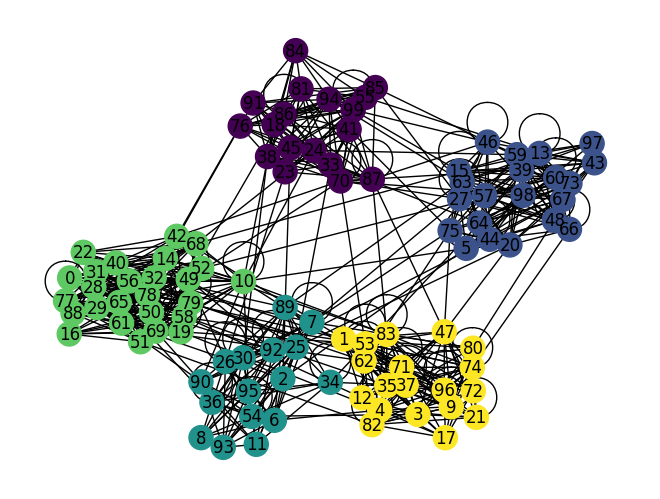

In [7]:
G, labels = create_graph(N,K,p_in,p_out)
nx.draw(nx.from_numpy_array(G), node_color=labels, with_labels=True)

<div id="generate_random_walks" >
    <h1 style="font-family:verdana;"> Generate random walks </h1>
</div>

- The first step is generating random walks that will act as our sentences,random walks are nothing more than\
random paths of different lengths extracted from our graph by following the steps below :

    1. Start from a Random Node.
    2. Select the Next Node : randomly choose the next node to visit from the current's node neighbors.
    3. Move to the Next Node.
    4. Repeat the Process.
    5. End of Walk : The walk ends once the specified maximum walk length is reached or if the current node doesn't have any neighbors.

In [8]:
def generate_random_walks(
    G : np.ndarray,
    num_walks : int,
    min_walk_length : int,
    max_walk_length : int
) -> list[np.ndarray]:

    walks = []

    indices = np.arange(G.shape[0])

    for _ in tqdm(range(num_walks)):

        start_node = np.random.randint(0, G.shape[0])
        walk = [start_node]

        length = np.random.randint(min_walk_length, max_walk_length)

        for _ in range(length):

            neighbors = indices[G[walk[-1], :] > 0]

            if len(neighbors) == 0:
                break

            walk.append(np.random.choice(neighbors))

        walks.append(np.array(walk).astype(int))

    return walks

In [9]:
walks = generate_random_walks(G, 1000, 5, 12)
print(walks[0].shape)

  0%|          | 0/1000 [00:00<?, ?it/s]

(10,)


<div id="random_walks_preprocessing" >
    <h1 style="font-family:verdana;"> Random walks preprocessing </h1>
</div>

- Similar to how we train skip-gram in the context of natural language processing our sequences had to be processes\
using a window of a given size (this size is a hyper-parameter) to construct a dataset where the input `X` is the center word
and the output `Y` is a context word.

For example given the following sentence processed with a half window of `1` which means the context of a word is composed off the word right before it and right after it : 

- Sentence : `a bird on a tree`.

- Context : 

| Target Word | Context      |
|-------------|--------------|
| a           | (bird)       |
| bird        | (a, on)      |
| on          | (bird, a)    |
| a           | (on, tree)   |
| tree        | (a)          |

- Dataset : 

| Target Word | Context Word |
|-------------|--------------|
| a           | bird         |
| bird        | a            |
| bird        | on           |
| on          | bird         |
| on          | a            |
| a           | on           |
| a           | tree         |
| tree        | a            |

In this section we will do a similar think but with random walks instead of sentences.


In [10]:
def window_process(
    walks : list[np.ndarray],
    half_window_size : int
) -> tuple[np.ndarray,np.ndarray]:

    x = []
    y = []

    for walk in tqdm(walks):

        for i, node in enumerate(walk):

            start = max(0, i - half_window_size)
            end = min(len(walk), i + half_window_size + 1)

            for j in range(start, end):

                if i != j:

                    x.append(node)
                    y.append(walk[j])

    x = np.array(x).astype(int)
    y = np.array(y).astype(int)

    return x, y

In [11]:
x, y = window_process(walks, 2)
print(x.shape, y.shape)

  0%|          | 0/1000 [00:00<?, ?it/s]

(29936,) (29936,)


<div id="model" >
    <h1 style="font-family:verdana;"> Model </h1>
</div>

- Skip Gram is a shallow neutral ntwork composed of two layers : 

    1. An input layer that transform the dimension of the input one hoe vectors corresponding the to each node in the batch to a lower dimension `D`.
    2. An output layer that predicts the context word.

**Note** : Instead of one-hot encoding the input node IDs then passing through an linear layer,and embedding layer can be used directly.

In [12]:
class SkipGram(nn.Module):
    
    def __init__(self, d : int, V : int):
        super(SkipGram, self).__init__()
        
        self.embedding = nn.Embedding(V, d)
        self.linear = nn.Linear(d, V)

    def forward(self, x : Tensor) -> Tensor:
        return self.linear(self.embedding(x))
    
    def fit(self, 
        x : Tensor, 
        y : Tensor, 
        batch_size : int,
        epochs : int, 
        lr : float,
        device : torch.device = torch.device('cpu')
    ) -> 'SkipGram':
        
        self.train().to(device)
        
        optimizer = optim.Adam(self.parameters(), lr=lr)

        dataset = TensorDataset(x, y)
        loader = DataLoader(dataset, batch_size=batch_size, shuffle=True)
        
        for epoch in range(epochs):

            running_loss = 0.0
                
            for x, y in tqdm(loader):

                x = x.to(device)
                y = y.to(device)
            
                optimizer.zero_grad()
                output = self.forward(x)
                loss = F.cross_entropy(output, y)
                loss.backward()
                optimizer.step()

                running_loss += loss.item() / len(loader)
                
            print(f'Epoch {epoch+1}/{epochs}, Loss {loss.item()}')

        return self

In [13]:
input_data = torch.tensor(x)
summary(SkipGram(8, N), input_data=input_data)

Layer (type:depth-idx)                   Output Shape              Param #
SkipGram                                 [29936, 100]              --
├─Embedding: 1-1                         [29936, 8]                800
├─Linear: 1-2                            [29936, 100]              900
Total params: 1,700
Trainable params: 1,700
Non-trainable params: 0
Total mult-adds (M): 50.89
Input size (MB): 0.24
Forward/backward pass size (MB): 25.86
Params size (MB): 0.01
Estimated Total Size (MB): 26.11

<div id="training" >
    <h1 style="font-family:verdana;"> Training </h1>
</div>

In [14]:
BATCH_SIZE = 64
EPOCHS = 10
LR = 0.001
D = 8

In [15]:
model = SkipGram(D, N).fit(
    torch.tensor(x), 
    torch.tensor(y), 
    batch_size=BATCH_SIZE, 
    epochs=EPOCHS, 
    lr=LR
)

  0%|          | 0/468 [00:00<?, ?it/s]

Epoch 1/10, Loss 4.539783000946045


  0%|          | 0/468 [00:00<?, ?it/s]

Epoch 2/10, Loss 4.204672336578369


  0%|          | 0/468 [00:00<?, ?it/s]

Epoch 3/10, Loss 3.9188060760498047


  0%|          | 0/468 [00:00<?, ?it/s]

Epoch 4/10, Loss 3.669658899307251


  0%|          | 0/468 [00:00<?, ?it/s]

Epoch 5/10, Loss 3.471069097518921


  0%|          | 0/468 [00:00<?, ?it/s]

Epoch 6/10, Loss 3.373492479324341


  0%|          | 0/468 [00:00<?, ?it/s]

Epoch 7/10, Loss 3.513991594314575


  0%|          | 0/468 [00:00<?, ?it/s]

Epoch 8/10, Loss 3.4906489849090576


  0%|          | 0/468 [00:00<?, ?it/s]

Epoch 9/10, Loss 3.3512189388275146


  0%|          | 0/468 [00:00<?, ?it/s]

Epoch 10/10, Loss 3.7753098011016846


<div id="visualizing_the_embeddings" >
    <h1 style="font-family:verdana;"> Visualizing the embeddings </h1>
</div>

- Reduce the dimensions of the vectors to two using `TSNE` so they can be plotted.

In [16]:
tsne = Pipeline([
    ('scaler', StandardScaler()),
    ('tsne', TSNE(n_components=2))
])

In [17]:
embeddings = torch.clone(model.embedding.weight.data).detach().cpu().numpy()
print(embeddings.shape)

(100, 8)


In [18]:
x1, x2 = tsne.fit_transform(embeddings).transpose()
print(x1.shape, x2.shape)

(100,) (100,)


<Axes: >

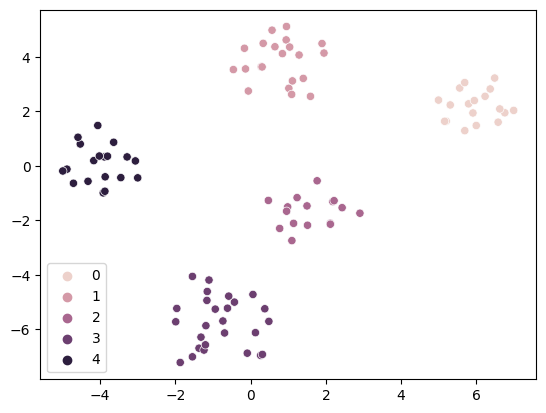

In [19]:
sns.scatterplot(x=x1, y=x2, hue=labels)

- we can see a clear separation between the embeddings of the nodes belonging to a different cluster.

<div id="trying_on_a_real_dataset" >
    <h1 style="font-family:verdana;"> Trying on a real dataset </h1>
</div>

- Now we will try the method on a real dataset and use the generated embeddings for the task of node classification.the chosen dataset is\
the `Cora` dataset which is Aacitation network of scientific papers in the field of machine learning. with 2,708 nodes and 5,278 edges.

<div id="downloading_the_dataset" >
    <h2 style="font-family:verdana;"> Downloading the dataset </h2>
</div>

In [20]:
dataset = Planetoid(root='/tmp/Cora', name='Cora')

Processing...
Done!


<div id="exploring_the_dataset" >
    <h2 style="font-family:verdana;"> Exploring the dataset </h2>
</div>

In [21]:
print(dataset[0])

Data(x=[2708, 1433], edge_index=[2, 10556], y=[2708], train_mask=[2708], val_mask=[2708], test_mask=[2708])


- The dataset contains the following attributes : 

    - **x** : a matrix where each row is a binary vector representing the feature vector of a given node.
    - **edge_index** : the edges of graph as a list of pairs of node IDs.
    - **y** : the label of each node.
    - **train_mask** : a binary array represents which node belongs to the train set and which doesn't.
    - **val_mask** : a binary array represents which node belongs to the validation set and which doesn't.
    - **test_mask** : a binary array represents which node belongs to the test set and which doesn't.

- Labels

In [22]:
y = dataset[0].y
values, counts = torch.unique(y, return_counts=True)

print(f"There are {len(values)} classes in the dataset")

for class_, count in zip(values, counts):
    print(f"Class {class_.item()} has {count.item()} samples")

There are 7 classes in the dataset
Class 0 has 351 samples
Class 1 has 217 samples
Class 2 has 418 samples
Class 3 has 818 samples
Class 4 has 426 samples
Class 5 has 298 samples
Class 6 has 180 samples


[Text(0.5, 0, 'Class'), Text(0, 0.5, 'Count')]

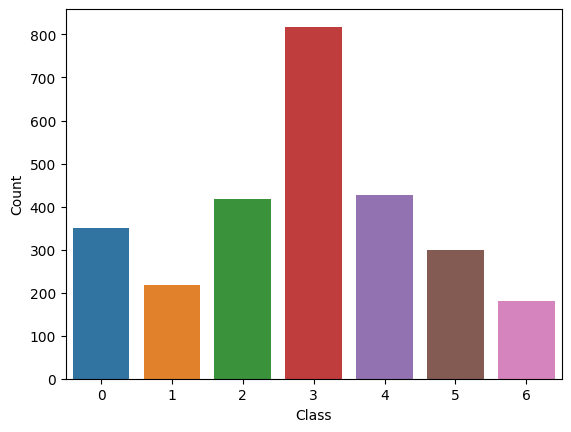

In [23]:
ax = sns.barplot(x=values.numpy(), y=counts.numpy())
ax.set(xlabel='Class', ylabel='Count')

- Splits

In [24]:
train_mask = dataset[0].train_mask
val_mask = dataset[0].val_mask
test_mask = dataset[0].test_mask

print(f"Train set has {train_mask.sum().item()} samples")
print(f"Validation set has {val_mask.sum().item()} samples")
print(f"Test set has {test_mask.sum().item()} samples")

Train set has 140 samples
Validation set has 500 samples
Test set has 1000 samples


- Convert the `edge_index` attribute to adjacency matrix.

In [25]:
G = to_dense_adj(dataset[0].edge_index)[0]
G = G + torch.eye(G.shape[0]) # Enforce self-connections
print(G.shape)

torch.Size([2708, 2708])


<div id="use_deep_walk_to_generate_embeddings" >
    <h2 style="font-family:verdana;"> Use DeepWalk to generate the embeddings</h2>
</div>

In [26]:
NUM_WALKS = 5 * G.shape[0]
MIN_WALK_LENGTH = 10
MAX_WALK_LENGTH = int(G.shape[0] ** 0.5)

In [27]:
walks = generate_random_walks(G.numpy(), NUM_WALKS, MIN_WALK_LENGTH, MAX_WALK_LENGTH)
print(len(walks))

  0%|          | 0/13540 [00:00<?, ?it/s]

13540


In [28]:
WINDOW_SIZE = 2
x, y = window_process(walks, WINDOW_SIZE)
print(x.shape, y.shape)

  0%|          | 0/13540 [00:00<?, ?it/s]

(1629748,) (1629748,)


In [29]:
BATCH_SIZE = 256
EPOCHS = 10
LR = 0.001
D = 192
DEVICE = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [30]:
model = SkipGram(D, G.shape[0]).fit(
    torch.tensor(x), 
    torch.tensor(y), 
    batch_size=BATCH_SIZE, 
    epochs=EPOCHS, 
    lr=LR,
    device=DEVICE
)

  0%|          | 0/6367 [00:00<?, ?it/s]

Epoch 1/10, Loss 3.042799234390259


  0%|          | 0/6367 [00:00<?, ?it/s]

Epoch 2/10, Loss 2.623286724090576


  0%|          | 0/6367 [00:00<?, ?it/s]

Epoch 3/10, Loss 2.369046926498413


  0%|          | 0/6367 [00:00<?, ?it/s]

Epoch 4/10, Loss 2.657578945159912


  0%|          | 0/6367 [00:00<?, ?it/s]

Epoch 5/10, Loss 2.583066701889038


  0%|          | 0/6367 [00:00<?, ?it/s]

Epoch 6/10, Loss 2.6142823696136475


  0%|          | 0/6367 [00:00<?, ?it/s]

Epoch 7/10, Loss 2.481638193130493


  0%|          | 0/6367 [00:00<?, ?it/s]

Epoch 8/10, Loss 2.2599844932556152


  0%|          | 0/6367 [00:00<?, ?it/s]

Epoch 9/10, Loss 2.37052845954895


  0%|          | 0/6367 [00:00<?, ?it/s]

Epoch 10/10, Loss 2.3266806602478027


<div id="use_the_embeddings_for_node_classification" >
    <h2 style="font-family:verdana;"> Use the embeddings for node classification </h2>
</div>

In [31]:
embeddings = torch.clone(model.embedding.weight.data).detach().cpu().numpy()
print(embeddings.shape)

(2708, 192)


In [32]:
dtrain, dtest, ytrain, ytest = train_test_split(embeddings, dataset[0].y.numpy(), test_size=0.2)

print(dtrain.shape, dtest.shape, ytrain.shape, ytest.shape)

(2166, 192) (542, 192) (2166,) (542,)


In [33]:
svc = Pipeline([
    ('scaler', StandardScaler()),
    ('svc', SVC())
])

In [34]:
svc.fit(dtrain, ytrain)

Pipeline(steps=[('scaler', StandardScaler()), ('svc', SVC())])

In [35]:
y_test_pred = svc.predict(dtest)
print(classification_report(ytest, y_test_pred))

              precision    recall  f1-score   support

           0       0.65      0.60      0.62        62
           1       0.90      0.78      0.84        46
           2       0.88      0.81      0.84        86
           3       0.62      0.90      0.73       145
           4       0.91      0.65      0.76        92
           5       0.84      0.70      0.77        70
           6       0.90      0.68      0.78        41

    accuracy                           0.76       542
   macro avg       0.81      0.73      0.76       542
weighted avg       0.79      0.76      0.76       542



<Axes: >

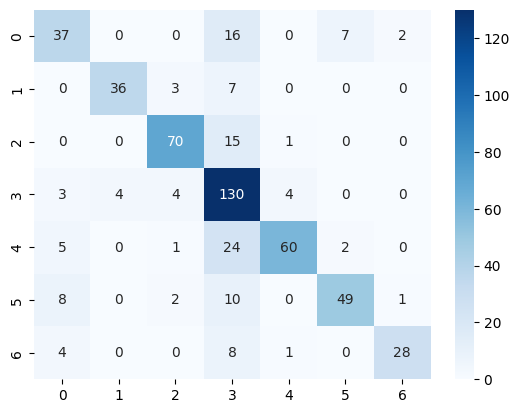

In [36]:
cm = confusion_matrix(ytest, y_test_pred)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')

<div id="conclusion" >
    <h1 style="font-family:verdana;"> Conclusion </h1>
</div>

conclusion, node embeddings like those generated by DeepWalk provide a powerful way to represent graph data in a compact and meaningful format.\
By leveraging random walks and principles from NLP, DeepWalk effectively captures the structural and semantic properties of nodes, enabling their\
use in tasks like classification and clustering. This project demonstrated the application of DeepWalk on both toy and real datasets,\
highlighting its potential and limitations. Future work could explore more advanced embedding techniques and apply them to diverse\
graph-based problems.

<div id="thank_you" >
    <h1 style="font-family:verdana;"> Thank You :) </h1>
</div>